*updated 16 Jan 2026, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 5303 "AI and Machine Learning in Ocean Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES5303_ML_ocean) page.

---
# 5. Convolutional Neural Networks

In the previous session we considered perceptrons and multi-layer neural networks. The fully connected nature of those networks means the degrees of freedom can get large and become unwieldly quickly. ***Convolution Neural Networks*** (CNNs) has an advantage in controlling the dimensionality of the networks, and have been found to be particularly skillful when dealing image/array data (e.g. for computer vision problems). CNNs are the focus of this session.

I am going do the implementation in quite a "raw" way first, before introducing the `DataLoader` object and also interfacing with `keras`, which makes the implementation more flexible and less "raw". It is probably good practice to try and go back to the previous session and redo what was done also.

> ## Key Objective(s)
> 1. Introduce the idea of a convolution, and the learning of a convolution kernel.
> 2. Applying CNNs to the same image classification and regression problem (cue for cursed cat images).
> 3. Introduce the `DataLoader` object that helps with data management (e.g. shuffling of data, batching)
> 4. Interfacing `PyTorch` with the `keras` interface to further smooth out the implementation of neural networks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

import torch
import torch.nn as nn
import torch.optim as optim

---
## a) Convolutions

First we talk about what ***convolutions*** are, then what is new about ***Convolutional Neural Networks*** (CNNs) should be fairly self-explanatory. 

Convolutions were sort of introducted in OCES 3301 in relation to ***filtering*** (in the context of time series data). Mathematically, for a ***kernel function*** $G(x, x')$, the convolution of $f(x)$ with $G(x, x')$, denoted $f\ast G$ is defined as (for the continuous case)
\begin{equation*}
    (f \ast G) (x) = \int f(x') G(x, x')\; \mathrm{d}x'.
\end{equation*}
For doing this in higher dimensions you just add more variables in, e.g. $f(x,y)$ and $G(x,x',y,y')$.

> NOTE: Most works you see would presumably use $K$ for kernel. I happen to use $G$ because I am used to seeing it as a ***Green's function***.

This looks a bit confusing maybe, but it's actually quite simple and easier to explain with a picture with the discrete case. Here the kernel $G$ is basically the red thing.

<img src="https://i.imgur.com/NbN8svq.jpeg" width="600" alt='conv2d'>

For this example I chose my kernel has ***size*** `(width, height) = (2, 2)` (because it's 2 by 2), and I chose uniform weights of $1/4$ for all kernel entries. I throw down the kernel onto the array (the solid red box), then act on it element-wise then sum it up as
\begin{equation*}
    \frac{1}{4}\cdot 1 + \frac{1}{4}\cdot 2 + \frac{1}{4}\cdot 5 + \frac{1}{4}\cdot 6 = \frac{1+2+5+6}{4} = \frac{14}{4} = 3.5,
\end{equation*}
and that becomes out new top-left entry in the result on the right.

I then move that kernel around the original array, in this case with a step size or ***stride*** of `(horizontal, vertical) = (1, 1)`. My top right entry in the new array would be
\begin{equation*}
    \frac{3+4+7+8}{4} = \frac{22}{4} = 5.5,
\end{equation*}
and we continue until we have done the whole array. In the definition of $(f \ast G)$ above as an integral, that's what the integral over the dummy variable $x'$ means: you slide the kernel $G$ along the function $x$, do an integral, and you do this for all possible values.

In the above discrete example, if my input is a `(4, 4)` array, then my convolved output would be `(3, 3)` with a size of 2 and stride of 1 (assuming my kernel is square in this case so I don't talk about the other dimension). Thus a convolution by default **reduces** the dimensionality, but picks out some of the essence of the features (e.g. the kernel above basically does an averaging over a window, and removes small-scale features that might not be important for learning).

If I don't like the changes of shapes for whatever reason I can decide to do some ***padding***. In this case a ***zero padding*** would bulk out the input array (right and bottom) edges with zeros, and then you pass a kernel through; my initial input is of size `(4, 4)`, padding makes the input size `(5, 5)`, so my convolved ouptut would be `(4, 4)`. The zero padding leads to the calculations
\begin{equation*}
    \frac{4+0+8+0}{4} = \frac{12}{4} = 3, \qquad \frac{16+0+0+0}{4} = 4,
\end{equation*}
as seen in the relevant entries above.

> NOTE: Neither the kernel size, strides and/or paddings need to be square/uniform. You can do whatever you like in principle, but certain choices makes setting up the CNN a bit easier; see later uses in PyTorch.
>
> Strictly speaking the above is a ***cross-correlation*** and not a convolution, the latter requires some reflections along the dimensions. In practice it doesn't really matter, because it just means the thing that ends up being trained is the flipped version of the convolutional layer, but two flips cancel out.

***Pooling*** works similarly but the operations and defaults are different. The example below shows what would be called ***max pooling***:

<img src="https://i.imgur.com/w2uERAj.jpeg" width="600" alt='pooling'>

The max pooling part is in green and it picks out the maximum of the values covered by the pooling kernel; because of how I set up the array, this basically picks out the value at the  bottom right corner covered by the pooling kernel. A thing to be aware of is that by default the stride of pooling layers is **equal** to the size of the kernel; in this example that ends up squashing the input array down from size `(4, 4)` to `(2, 2)`. You can further imagine other operations one could do specify (e.g. averaging, fractional maximums).

### Implementation in `PyTorch`

To see what these things do I am going to borrow the help of the three ad-hoc TAs and explicitly specify my convolution and pooling layers. Summoning the TAs first.

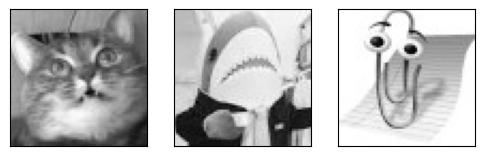

In [2]:
import requests
from PIL import Image
from io import BytesIO

targets_path = {
    "miffy_gormless" : "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/miffy_gormless.jpg",
    "blauhaj" : "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/blauhaj.jpg",
    "clippy" : "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/clippy.jpg",
}

targets = {}

for file_name, file_url in targets_path.items():
    response = requests.get(file_url)
    targets[file_name] = Image.open(BytesIO(response.content))

# do some plots to show decomposition
fig = plt.figure(figsize=(6, 2.5))

i = 0
for key in targets:
    X = np.array(targets[key])
    ax = plt.subplot(1, 3, i+1)
    ax.imshow(X, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);
    i += 1    

I am going to define some three by three kernels and hit the ad-hoc TAs with those. Things I am doing are:

* Creating a dictionary `kernels` that will be cycled through. Each of these have a name and I am defining the things using the `torch.tensor` object straight away (I could have defined it as a numpy array then convert them into `LongTensors` accordingly).
* The image input is of size `(64, 64)`, but I promote them to size `(1, 1, 64, 64)` tensors via `.expand()`. The two `1`s are for 1 sample (because it's per image) and 1 channel (because it's grayscale).
* My kernels are promoted from `(3, 3)` to `(1, 1, 3, 3)` for the same reason.

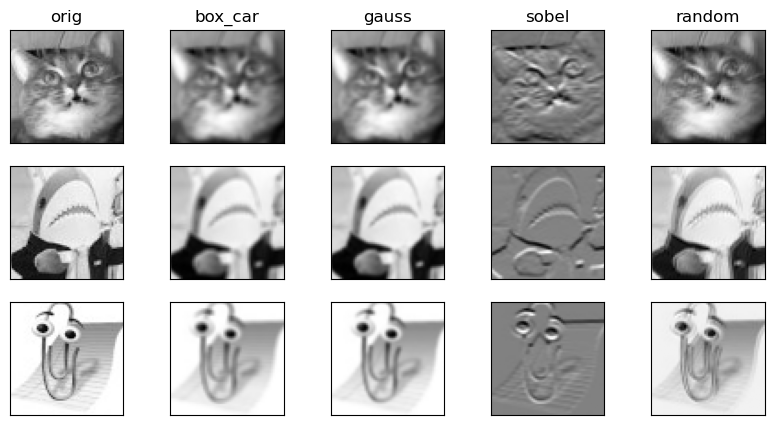

In [3]:
# plots to show convolutions with some fixed kernels
torch.manual_seed(4167) # specify a seed to fix the randomness

kernels = {"box_car" : torch.tensor([[1/9, 1/9, 1/9], [1/9, 1/9, 1/9], [1/9, 1/9, 1/9]]),
           "gauss" : torch.tensor([[1/16, 2/16, 1/16], [2/16, 4/16, 2/16], [1/16, 2/16, 1/16]]),
           "sobel" : torch.tensor([[-1., -2., -1.], [0., 0., 0.], [1., 2., 1.]]),
           "random" : torch.randn(3, 3),
          }

fig = plt.figure(figsize=(10, 5))

i = 0
for key in targets:
    X = np.array(targets[key])
    X = torch.FloatTensor(X).expand(1, 1, 64, 64)

    j = 0
    ax = plt.subplot(len(targets), len(kernels)+1, 5*i + j+1)
    ax.imshow(X[0, 0, :, :], cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);
    if i == 0:
        ax.set_title("orig")
        
    for kernel in kernels:
        j += 1
        weights = kernels[kernel].expand(1, 1, 3, 3)
        X_conv = nn.functional.conv2d(X, weights)
        ax = plt.subplot(len(targets), len(kernels)+1, 5*i + j+1)
        ax.imshow(X_conv[0, 0, :, :], cmap="gray")
        ax.set_xticks([]); ax.set_yticks([]);
        if i == 0:
            ax.set_title(f"{kernel}")
        
    i += 1

I've chosen two that does the blurring and one that is for edge detection. The random one with the chosen seed does some sort of jiggling instead. The output in this case has shape `(62, 62)`. This comes from the formula (only showing one of these)
\begin{equation*}
    H_{\rm out} = \left\lfloor \frac{H_{\rm in} + 2\cdot \mbox{padding} - \mbox{dilate}(\mbox{kernel size}-1) - 1}{\mbox{stride}} + 1\right\rfloor,
\end{equation*}
where $\lfloor\cdot\rfloor$ is the floor function that takes the integer part of the answer. By default there is no padding, stride is 1, and dilation (look up what that is if you want) is 0, and input size is 64, so
\begin{equation*}
    H_{\rm out} = \left\lfloor \frac{64 + 2\cdot0 - 1(3-1) - 1}{1} + 1\right\rfloor = \left\lfloor 64 + 0 - 2 - 1 + 1\right\rfloor = 62.
\end{equation*}

Below is a calculator coded up by Jonathan to do the above computation, which may be useful in determining input/output sizes for when you create your own CNNs.

In [4]:
# JL: simple functions for calculating conv shape
def ConvShapeCalculator(input_shape, padding, dilate, kernel_size, stride):
    output_shape = np.floor((input_shape + 2*padding - dilate * (kernel_size - 1) - 1) / stride + 1)
    return output_shape

conv_input = dict(input_shape=62, padding=0, dilate=1, kernel_size=3, stride=1)
output_shape = ConvShapeCalculator(**conv_input)
print(f"Input shape: {conv_input['input_shape']} --> Output shape: {output_shape:.0f}")

Input shape: 62 --> Output shape: 60


We do the same for a few choices of pooling, all of them with kernel size `(2, 2)`.

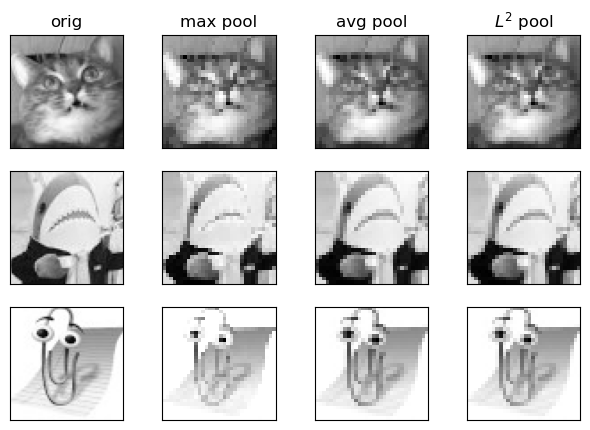

In [5]:
# plots to show effect of pooling
fig = plt.figure(figsize=(9.5, 5))

i = 0
for key in targets:
    X = np.array(targets[key])
    X = torch.FloatTensor(X).expand(1, 1, 64, 64)

    ax = plt.subplot(len(targets), 4+1, 5*i + 1)
    ax.imshow(X[0, 0, :, :], cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);
    if i == 0:
        ax.set_title("orig")
        
    X_pool = nn.functional.max_pool2d(X, (2, 2))
    ax = plt.subplot(len(targets), 4+1, 5*i + 2)
    ax.imshow(X_pool[0, 0, :, :], cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);
    if i == 0:
        ax.set_title(f"max pool")
        
    X_pool = nn.functional.avg_pool2d(X, (2, 2))
    ax = plt.subplot(len(targets), 4+1, 5*i + 3)
    ax.imshow(X_pool[0, 0, :, :], cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);
    if i == 0:
        ax.set_title(f"avg pool")
        
    X_pool = nn.functional.lp_pool2d(X, 2, (2, 2))  # (input, type, kernel size)
    ax = plt.subplot(len(targets), 4+1, 5*i + 4)
    ax.imshow(X_pool[0, 0, :, :], cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);
    if i == 0:
        ax.set_title(f"$L^2$ pool")
        
    i += 1

Here the outputs have size `(32, 32)` following the above formula but noting that stride by default is the same size as the kernel, so we have instead
\begin{equation*}
    H_{\rm out} = \left\lfloor \frac{64 + 2\cdot0 - 1(2-1) - 1}{2} + 1\right\rfloor = \left\lfloor \frac{64 + 0 - 1 - 1}{2} + 1\right\rfloor = 31 + 1 = 32.
\end{equation*}

This calculation, if slightly annoying, are important for later on when setting up the CNNs.

> <span style="color:red">Q.</span> See if you can interpret why the non-random kernels are doing what they are doing. Then have a look at the random one and see why it is doing whatever it is they are doing.
> 
> <span style="color:red">Q.</span> Try writing your own kernels for doing the convolution.
> 
> <span style="color:red">Q.</span> There are other choices of pooling, have a look at those. (Be a bit careful with `fractional_max_pool2d` if you do use it.)
>
> <span style="color:red">Q.</span> The above was demonstrated for data with one channel (grayscale images). Try adapting this to the coloured broccolie image that I loaded at some point (e.g. session 1) and see how you would modify the kernels accordingly, noting we now have three channels to deal with.

---
## b) CNNs with `PyTorch`

In a nutshell, what CNNs do is that entires in the kernels of the convolutional layers are themselves weights that can be adjusted, and are thus part of the model parameters or control variables that are to be learned, but otherwise you wrap them up exactly as you would for MLPs with hidden layers etc. as usual. You might suspect CNNs have the following advantages over the MLPs because:

* Convolution operations are richer, and leaves specific structures in the data intact that may be useful for classification/regression.
* The convolutions and pooling inherently reduce the dimension in the data, which is potentially useful for learning, and definitely a bonus for computation purposes.
* The convolutions with a small kernel inherently has fewer model parameters, which also provides additional controls on the feature space dimension.

CNNs work particularly well when there are structures that are inherent in the data, such as images.

### Classification

We now have all the pieces we need to construct CNNs. Going to do the classification problem first, as this is slightly easier problem than regression. Loading the data first.

In [6]:
# don't read the headers

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "cat.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/cat.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df_cats = pd.read_csv(path, header=None).T # make "features" the axis=-1
X_cats = df_cats.values

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "dog.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/dog.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df_dogs = pd.read_csv(path, header=None).T # make "features" the axis=-1
X_dogs = df_dogs.values

# split to train/test/validate as before
seed = 42
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15
test_valid_ratio = valid_ratio + test_ratio
assert train_ratio + valid_ratio + test_ratio == 1

# Expected no. of samples
print()
total_sample = 80*2
train_sample = int(train_ratio*total_sample)
valid_sample = int(valid_ratio*total_sample)
test_sample = total_sample - train_sample - valid_sample
print(f"Expected no. of samples (train, test, valid): {train_sample, test_sample, valid_sample}")

X_total = np.concatenate((X_cats, X_dogs), axis=0)
Y_total = np.concatenate((np.ones(int(total_sample/2)), np.zeros(int(total_sample/2))))

# train-(test&valid) split
X_train, X_test, Y_train, Y_test = train_test_split(
    X_total, Y_total, test_size=test_valid_ratio, random_state=seed,)
# split test set to test and valid set
X_test, X_valid, Y_test, Y_valid = train_test_split(
    X_test, Y_test, test_size=valid_ratio/test_valid_ratio, random_state=seed,)

# check the shape
print()
print(f"X_train shape : {X_train.shape}; Y_train shape: {Y_train.shape}")
print(f"X_valid shape: {X_valid.shape}; Y_valid shape: {Y_valid.shape}")
print(f"X_test shape: {X_test.shape}; Y_test shape: {Y_test.shape}")

# # scale and redefine the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train, X_valid, X_test = \
  scaler.transform(X_train), scaler.transform(X_valid), scaler.transform(X_test)

# Side Note:
# JL: images are always 0 - 255. Can use MinMaxScalar to scale instead
# X_train, X_valid, X_test = (X_train - 0)/ (255 - 0), X_valid / 255, X_test / 255

# check the range of values
print()
print(f"X_train : {X_train.min()}...{X_train.max()}")
print(f"X_valid : {X_valid.min()}...{X_valid.max()}")
print(f"X_test :  {X_test.min()}...{X_test.max()}")

# to tensor

X_train, Y_train = torch.FloatTensor(X_train), torch.LongTensor(Y_train)
X_test, Y_test = torch.FloatTensor(X_test), torch.LongTensor(Y_test)
X_valid, Y_valid = torch.FloatTensor(X_valid), torch.LongTensor(Y_valid)

loading data remotely
loading data remotely

Expected no. of samples (train, test, valid): (112, 24, 24)

X_train shape : (112, 4096); Y_train shape: (112,)
X_valid shape: (24, 4096); Y_valid shape: (24,)
X_test shape: (24, 4096); Y_test shape: (24,)

X_train : -2.335741709402446...2.656062140273782
X_valid : -2.2980798425108357...2.604693316176747
X_test :  -2.3648983633730407...2.5768492533329166


The only new thing I need to do really is to specify the structure of the CNN. The one below I took from a MNIST classification task, but I reduced various values for the sake of it. The structure is that we have

* Input image of size `(64, 64)`, grayscale so one channel, thus input size of `(n, 1, 64, 64)`.
* First convolutional layer that does
  - 2d convolution with `(in channel, out channel, kernel size) = (1, 6, 5)`, so input is now of size `(6, 60, 60)` using the above formula (in this case you take 5-1 = 4 pixels off both ends)
  - activation with ReLU
  - max pool of size 2 to give an output of `(6, 30, 30)` using above formula (or in this case the number of pixels is even, so you can basically divide by 2)
* Second convolutional layer that does
  - 2d convolution with `(6, 10, 5)`, so input is now of size `(10, 26, 26)` (formula, or shave 4 pixels off)
  - activation with ReLU
  - max pool of size 2 to give an output of `(10, 13, 13)` (formula, or basically divide by 2)
* Flatten the image so the input is now a tensor of size `(10 * 13 * 13)` using `x.view(-1, 10*13*13)`
* Passed through some linear layers as in the MLP case as `10 * 13 * 13 -> 60 -> 30 -> 2` with ReLU activation as appropriate. The last one is `2` because we only have two outputs (cats or dogs).

In [7]:
class cnn_classification(nn.Module):
    def __init__(self):
        super(cnn_classification, self).__init__()

        # input at (1, 64, 64)

        # convolutional layer 1 & max pool layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),    # now (6, 60, 60)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # now (6, 30, 30)
        )

        # convolutional layer 2 & max pool layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 10, 5),   # now (10, 26, 26)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # now (10, 13, 13)
        )

        self.layer3 = nn.Sequential(
            nn.Linear(10 * 13 * 13, 60),
            nn.ReLU(),
            nn.Linear(60, 30),
            nn.ReLU(),
            nn.Linear(30, 2)      # because two possible outputs
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 10 * 13 * 13)
        out = self.layer3(out)
        return out

Going to define the training loop and some of the visualisation routines manually again (this is just copy and paste from last time).

In [8]:
# wrap the training up

def training(model, optimizer, J, X_train, Y_train, X_valid, Y_valid,
             num_epochs=500, out_epoch=50):

    # define things to dump into for loss curve
    train_J = np.zeros(num_epochs)
    valid_J = np.zeros(num_epochs)

    for epoch in range(num_epochs):

        # iteration step

        model.train()  # put the model in training mode (taping is on)
        optimizer.zero_grad()  # clear gradients if it exists (from loss.backward())
        Y_pred = model(X_train)  # feed-forward
        J_train = J(Y_pred, Y_train) # compute loss
        J_train.backward()  # back propagation
        optimizer.step()  # iterate
        model.eval()   # put the model in evaluation mode (taping is off for diags below)

        # diagnostics: evaluation of metrics as we go along
        with torch.no_grad():  # force no taping just in case
            Y_pred = model(X_valid)
            J_valid = J(Y_pred, Y_valid)
            train_J[epoch] = J_train.item()
            valid_J[epoch] = J_valid.item()

        if (epoch + 1) % out_epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, "
                + f"Train Loss: {J_train.item():.4f}, "
                + f"Validation Loss: {J_valid.item():.4f}")

    return model, train_J, valid_J

# do model prediction and evaluate skill
def classification_skill(predictions, truths):
    dum = predictions.numpy()
    Y_pred = np.zeros(dum.shape[0])
    N = len(Y_pred)
    for i in range(N):
        Y_pred[i] = np.argmax(dum[i, :])
    skill_all = np.sum(Y_pred == truths.numpy())

    print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
    print(" ")

# plot out the predictions (circles should lie on top of crosses if completely correct)
def classification_plot(predictions, Y_test):

    dum = predictions.numpy()
    Y_pred = np.zeros(dum.shape[0])
    N = len(Y_pred)
    for i in range(N):
        Y_pred[i] = np.argmax(dum[i, :])
    
    fig = plt.figure(figsize=(10, 2))
    ax = plt.axes()
    ax.plot(Y_pred, 'bx', label="predictions")
    ax.plot(Y_test, 'ro', fillstyle="none", label="truth")
    ax.set_ylim([-0.3, 1.3])
    ax.set_xlabel("index")
    ax.legend()
    ax.grid()
    
    accuracy = np.sum(Y_pred == Y_test.numpy()) / N
    ax.set_title(f"accuracy = {accuracy*100:.2f}%");

    return fig

We use entropy loss and Adam as before. We can leverage the same training loops as previously defined, and once we massage the data accordingly (because the CNN is expecting images of size `(n, 1, 64, 64)` rather `(n, 64*64)` as in the MLP case), then we can pass that to the subroutine for model training. We proceed straight away to the plotting of the loss curve and evaluation of model skill on test set.

> NOTE: I find I need a slightly smaller learning rate here.

In [9]:
# training a CNN
torch.manual_seed(1234)

model = cnn_classification()
learning_rate = 0.00005
J = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # default is 0.001

# change the shape of input for the CNN
X_train = X_train.view(-1, 1, 64, 64)
X_valid = X_valid.view(-1, 1, 64, 64)
X_test = X_test.view(-1, 1, 64, 64)

# do the actual training
model, train_J, valid_J = training(model, optimizer, J,
                                   X_train, Y_train,
                                   X_valid, Y_valid,
                                   num_epochs=300, out_epoch=30)

Epoch 30/300, Train Loss: 0.6697, Validation Loss: 0.6689
Epoch 60/300, Train Loss: 0.5838, Validation Loss: 0.5804
Epoch 90/300, Train Loss: 0.4427, Validation Loss: 0.4558
Epoch 120/300, Train Loss: 0.3094, Validation Loss: 0.3674
Epoch 150/300, Train Loss: 0.2260, Validation Loss: 0.3292
Epoch 180/300, Train Loss: 0.1711, Validation Loss: 0.3032
Epoch 210/300, Train Loss: 0.1284, Validation Loss: 0.2807
Epoch 240/300, Train Loss: 0.0943, Validation Loss: 0.2599
Epoch 270/300, Train Loss: 0.0677, Validation Loss: 0.2447
Epoch 300/300, Train Loss: 0.0481, Validation Loss: 0.2349


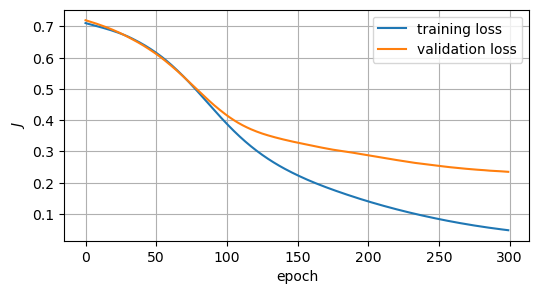

In [10]:
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_J, label="training loss")
ax.plot(valid_J, label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

training set:
overall skill: 112 correct out of 112 (100.00%)
 
test     set:
overall skill: 20 correct out of 24 (83.33%)
 


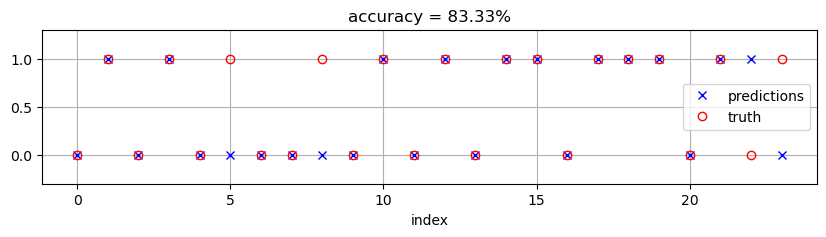

In [11]:
with torch.no_grad():
    predictions_train = model(X_train)
    predictions_test = model(X_test)

print("training set:")
classification_skill(predictions_train, Y_train)
print("test     set:")
classification_skill(predictions_test, Y_test)

fig = classification_plot(predictions_test, Y_test)

Looks ok? Could probably tune it accordingly to get a better score (e.g. learning rates, details of the layers). Also, these things tend to work better with more samples; I've only given it 64 samples each of cats and dogs.

> <span style="color:red">Q.</span> Probably need more epoches because the train loss hasn't flattened yet. Increase it and see what changes.

### CNN for regression

For the regression problem I am going to predict top half from bottom or vice-versa just with cats. More or less going to use the same structure, but the differences are some numbers, namely
* The input is now of size `(n, 1, 64, 32)`, so I need to keep track of how the image sizes change as it passes through the layers.
* Once I get to the linear layers I need to expand it back to images of size $64\times32 = 2048$, so the linear layers have different numbers in them for the scaling up of the values (before it was scaling down of values to $2$).

The various relevant numbers are given below as in-line comments.

> NOTE: If we use the PyTorch convention the inputs should probably be of size `(sample size, channel, height, width) = (n, 1, 32, 64)`, but again it practice it doesn't really matter because the dimension is just a label, and as long as I do things consistently it should be fine.

In [12]:
# cnn adjusted for regression
class cnn_regression(nn.Module):
    def __init__(self):
        super(cnn_regression, self).__init__()

        # input at (1, 64, 32)

        # convolutional layer 1 & max pool layer 1
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, 5),    # now (6, 60, 28)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # now (6, 30, 14)
        )

        # convolutional layer 2 & max pool layer 2
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 10, 5),   # now (10, 26, 10)
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),  # now (10, 13, 5)
        )

        # a more bulky final linear layer
        # self.layer3 = nn.Sequential(
            # nn.Linear(10 * 13 * 5, 1000), # expand these up to 2048 eventually
            # nn.ReLU(),
            # nn.Linear(1000, 1500),
            # nn.ReLU(),
            # nn.Linear(1500, 2048)
        # )

        self.layer3 = nn.Sequential(
            nn.Linear(10 * 13 * 5, 1000), # expand these up to 2048 eventually
            nn.ReLU(),
            nn.Linear(1000, 2048)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(-1, 10 * 13 * 5)
        out = self.layer3(out)  # this block is going to be too big no?
        return out

Below is the same code as before to split the image in half and doing the data conversion (we now what `FloatTensors` for everything).

In [13]:
# subroutine to split top and bottom half of pixels: reshape, split, then flatten for sklearn
def split_top_bottom(data):
    n, width = data.shape[0], int(np.sqrt(data.shape[1]))
    data = np.reshape(data, (n, width, width))
    top_half, bottom_half = data[:, :, 0:width//2], data[:, :, width//2::]
    top_half = np.reshape(top_half, (n, width*width//2))
    bottom_half = np.reshape(bottom_half, (n, width*width//2))

    return top_half, bottom_half

# Expected no. of samples
seed = 42
train_ratio = 0.7
valid_ratio = 0.15
test_ratio = 0.15
test_valid_ratio = valid_ratio + test_ratio
assert train_ratio + valid_ratio + test_ratio == 1

total_sample = 80*1
train_sample = int(train_ratio*total_sample)
valid_sample = int(valid_ratio*total_sample)
test_sample = total_sample - train_sample - valid_sample

X_total = X_cats

# train-(test&valid) split
X_train, X_test = train_test_split(
    X_total, test_size=test_valid_ratio, random_state=seed,)
# split test set to test and valid set
X_test, X_valid = train_test_split(
    X_test, test_size=valid_ratio/test_valid_ratio, random_state=seed,)

# create Y
X_train, Y_train = split_top_bottom(X_train)
X_valid, Y_valid = split_top_bottom(X_valid)
X_test, Y_test = split_top_bottom(X_test)

# scale and redefine the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train, X_valid, X_test = \
  scaler.transform(X_train), scaler.transform(X_valid), scaler.transform(X_test)

scale_X, scale_Y = StandardScaler().fit(X_train), StandardScaler().fit(Y_train)
X_train, Y_train = scale_X.transform(X_train), scale_Y.transform(Y_train)
X_test, Y_test = scale_X.transform(X_test), scale_Y.transform(Y_test)
X_valid, Y_valid = scale_X.transform(X_valid), scale_Y.transform(Y_valid)

# to tensor
X_train, Y_train = torch.FloatTensor(X_train), torch.FloatTensor(Y_train)
X_test, Y_test = torch.FloatTensor(X_test), torch.FloatTensor(Y_test)
X_valid, Y_valid = torch.FloatTensor(X_valid), torch.FloatTensor(Y_valid)

# check the range of values
print()
print(f"X_train : {X_train.min()}...{X_train.max()}")
print(f"X_valid : {X_valid.min()}...{X_valid.max()}")
print(f"X_test :  {X_test.min()}...{X_test.max()}")


X_train : -3.107675552368164...2.7110884189605713
X_valid : -3.272451639175415...2.5979435443878174
X_test :  -3.2001166343688965...2.801511764526367


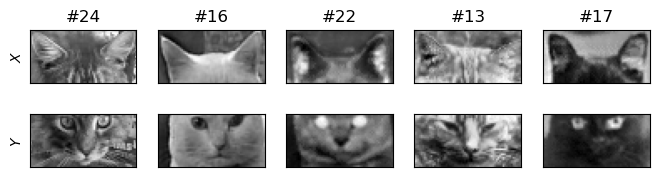

In [14]:
# quick plots to see the images
ind = np.arange(train_sample)
np.random.shuffle(ind)  # syntax for shuffle: not used like a function with input output...

# sample show (on-the-fly reshape data)
fig = plt.figure(figsize=(8, 2))
for i in range(5):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(np.reshape(X_train[ind[i], :], (64, 32)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    if i == 0:
        ax.set_ylabel("$X$")
    ax.set_xticks([]); ax.set_yticks([]);

    ax = plt.subplot(2, 5, i+1+5)
    ax.imshow(np.reshape(Y_train[ind[i], :], (64, 32)).T, cmap="gray")
    if i == 0:
        ax.set_ylabel("$Y$")
    ax.set_xticks([]); ax.set_yticks([]);

The below code defines the regression problem by specifying the choice of loss (in this case MSE loss), using Adam as before, and pass it through the training again.

> NOTE: The below might be a slow. If we want to not change the CNN structure then we could speed it up by ***batching***; see extended exercise on what that is.
>
> <span style="color:red">WARNING!</span> If the training ends up eating up too much of your available memory on the computer, I would suggest removing some layers, particularly the linear ones at the end.

In [15]:
# regression example: prediction bottom from top

torch.manual_seed(1234)

model = cnn_regression()
learning_rate = 0.0001
J = nn.MSELoss()  # one choice for regression problems
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # default is 0.001

# change the shape of input for the CNN
# X's go in as a 2d to be pass through the Conv2d
X_train = X_train.view(-1, 1, 64, 32) 
X_test  = X_test.view(-1, 1, 64, 32) 
X_valid = X_valid.view(-1, 1, 64, 32)

# Y's go in as 1d tensors along feature dimension after the linear layer
# no reshape here, but need to reshape for visualising later

# do the actual training
model, train_J, valid_J = training(model, optimizer, J,
                                   X_train, Y_train,
                                   X_valid, Y_valid,
                                   num_epochs=300, out_epoch=20)

Epoch 20/300, Train Loss: 0.9325, Validation Loss: 1.1578
Epoch 40/300, Train Loss: 0.7304, Validation Loss: 0.8707
Epoch 60/300, Train Loss: 0.6318, Validation Loss: 0.7857
Epoch 80/300, Train Loss: 0.5552, Validation Loss: 0.7725
Epoch 100/300, Train Loss: 0.4736, Validation Loss: 0.7690
Epoch 120/300, Train Loss: 0.3998, Validation Loss: 0.7680
Epoch 140/300, Train Loss: 0.3360, Validation Loss: 0.7772
Epoch 160/300, Train Loss: 0.2815, Validation Loss: 0.7986
Epoch 180/300, Train Loss: 0.2336, Validation Loss: 0.8239
Epoch 200/300, Train Loss: 0.1908, Validation Loss: 0.8551
Epoch 220/300, Train Loss: 0.1535, Validation Loss: 0.8890
Epoch 240/300, Train Loss: 0.1219, Validation Loss: 0.9213
Epoch 260/300, Train Loss: 0.0969, Validation Loss: 0.9465
Epoch 280/300, Train Loss: 0.0768, Validation Loss: 0.9720
Epoch 300/300, Train Loss: 0.0603, Validation Loss: 0.9997


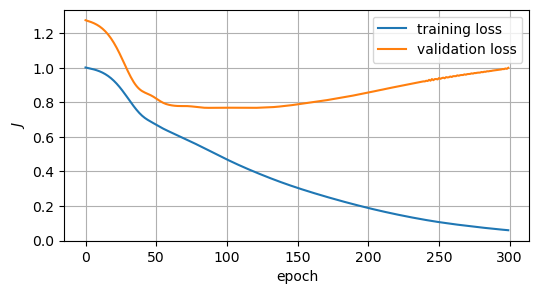

In [16]:
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_J, label="training loss")
ax.plot(valid_J, label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

Below massages data accordingly (e.g. `(n, 1, 2048)` to `(n, 64, 32)`), makes the predictions and then plots out the results. For certain operations I need to convert the tensor objects back to `numpy` arrays.

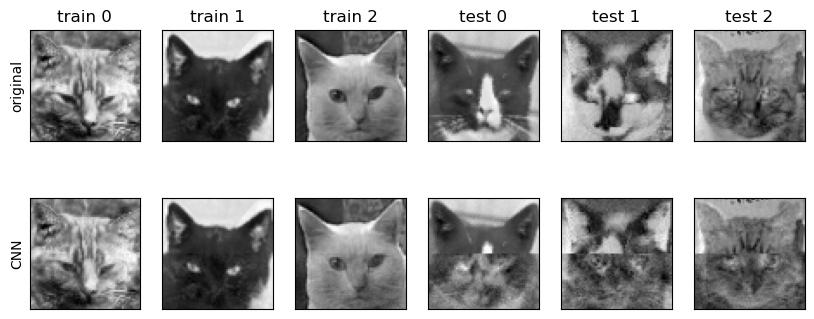

In [17]:
# could be passed accordingly to plotting commands (internally convert to np arrays presumably)
# going to convert here just so I can basically lift code directly from before
X_train_plot = X_train.view(-1, 64*32).numpy()
Y_train_plot = Y_train.numpy()

X_test_plot = X_test.view(-1, 64*32).numpy()
Y_test_plot = Y_test.numpy()

ind_train = np.arange(train_sample)
np.random.shuffle(ind_train)

ind_test = np.arange(test_sample)
np.random.shuffle(ind_test)

fig, ax = plt.subplots(figsize=(10, 4), nrows=2, ncols=6)

with torch.no_grad():
    Y_pred = model(X_train).view(-1, 64*32).numpy()

for j in range(0, 3):
    ind = ind_train[j]
    ax[0][j].imshow(np.hstack((np.reshape(X_train_plot[ind, :], (64, 32)), 
                               np.reshape(Y_train_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")
    ax[0][j].set_title(f"train {j}")

    ax[1][j].imshow(np.hstack((np.reshape(X_train_plot[ind, :], (64, 32)), 
                               np.reshape(Y_pred[ind, :], (64, 32)))).T, 
                    cmap="gray")

with torch.no_grad():
    Y_pred = model(X_test).view(-1, 64*32).numpy()

for j in range(3, 6):
    ind = ind_test[j]
    ax[0][j].imshow(np.hstack((np.reshape(X_test_plot[ind, :], (64, 32)), 
                               np.reshape(Y_test_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")
    ax[0][j].set_title(f"test {j-3}")

    ax[1][j].imshow(np.hstack((np.reshape(X_test_plot[ind, :], (64, 32)), 
                               np.reshape(Y_pred[ind, :], (64, 32)))).T, 
                    cmap="gray")

for i in range(2):
    for j in range(6):
        ax[i][j].set_xticks([]); ax[i][j].set_yticks([]);
        if j == 0:
            ax[0][j].set_ylabel("original")
            ax[1][j].set_ylabel("CNN")

Just for completeness, going to predict the top from the bottom. The code below basically only changes the data splitting part and plot ordering.

In [18]:
# do the reverse: predict top from bottom

X_total = X_cats

# train-(test&valid) split
X_train, X_test = train_test_split(
    X_total, test_size=test_valid_ratio, random_state=seed,)
# split test set to test and valid set
X_test, X_valid = train_test_split(
    X_test, test_size=valid_ratio/test_valid_ratio, random_state=seed,)

# create Y
Y_train, X_train = split_top_bottom(X_train)
Y_valid, X_valid = split_top_bottom(X_valid)
Y_test, X_test = split_top_bottom(X_test)

# scale and redefine the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train, X_valid, X_test = \
  scaler.transform(X_train), scaler.transform(X_valid), scaler.transform(X_test)

scale_X, scale_Y = StandardScaler().fit(X_train), StandardScaler().fit(Y_train)
X_train, Y_train = scale_X.transform(X_train), scale_Y.transform(Y_train)
X_test, Y_test = scale_X.transform(X_test), scale_Y.transform(Y_test)
X_valid, Y_valid = scale_X.transform(X_valid), scale_Y.transform(Y_valid)

# to tensor
X_train, Y_train = torch.FloatTensor(X_train), torch.FloatTensor(Y_train)
X_test, Y_test = torch.FloatTensor(X_test), torch.FloatTensor(Y_test)
X_valid, Y_valid = torch.FloatTensor(X_valid), torch.FloatTensor(Y_valid)

# check the range of values
print()
print(f"X_train : {X_train.min()}...{X_train.max()}")
print(f"X_valid : {X_valid.min()}...{X_valid.max()}")
print(f"X_test :  {X_test.min()}...{X_test.max()}")
print(" ")

torch.manual_seed(1234)

model = cnn_regression()
learning_rate = 0.0001
J = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # default is 0.001

X_train = X_train.view(-1, 1, 64, 32) 
X_test  = X_test.view(-1, 1, 64, 32) 
X_valid = X_valid.view(-1, 1, 64, 32)

model, train_J, valid_J = training(model, optimizer, J, 
                                   X_train, Y_train,  
                                   X_valid, Y_valid,
                                   num_epochs=300, out_epoch=20)


X_train : -2.623854875564575...2.8531572818756104
X_valid : -2.7254817485809326...2.8685531616210938
X_test :  -2.7254817485809326...2.8348171710968018
 
Epoch 20/300, Train Loss: 0.9328, Validation Loss: 1.1258
Epoch 40/300, Train Loss: 0.7447, Validation Loss: 0.7858
Epoch 60/300, Train Loss: 0.6348, Validation Loss: 0.7029
Epoch 80/300, Train Loss: 0.5405, Validation Loss: 0.6279
Epoch 100/300, Train Loss: 0.4557, Validation Loss: 0.5960
Epoch 120/300, Train Loss: 0.3725, Validation Loss: 0.5827
Epoch 140/300, Train Loss: 0.2982, Validation Loss: 0.5900
Epoch 160/300, Train Loss: 0.2389, Validation Loss: 0.6091
Epoch 180/300, Train Loss: 0.1937, Validation Loss: 0.6298
Epoch 200/300, Train Loss: 0.1582, Validation Loss: 0.6539
Epoch 220/300, Train Loss: 0.1287, Validation Loss: 0.6830
Epoch 240/300, Train Loss: 0.1041, Validation Loss: 0.7084
Epoch 260/300, Train Loss: 0.0834, Validation Loss: 0.7377
Epoch 280/300, Train Loss: 0.0660, Validation Loss: 0.7610
Epoch 300/300, Train Lo

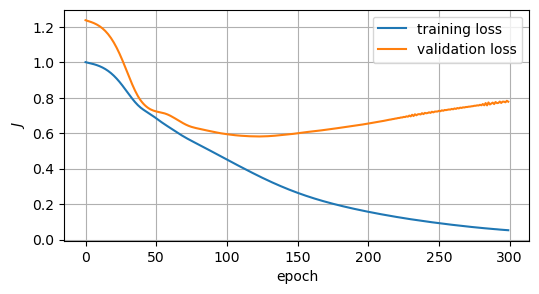

In [19]:
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_J, label="training loss")
ax.plot(valid_J, label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

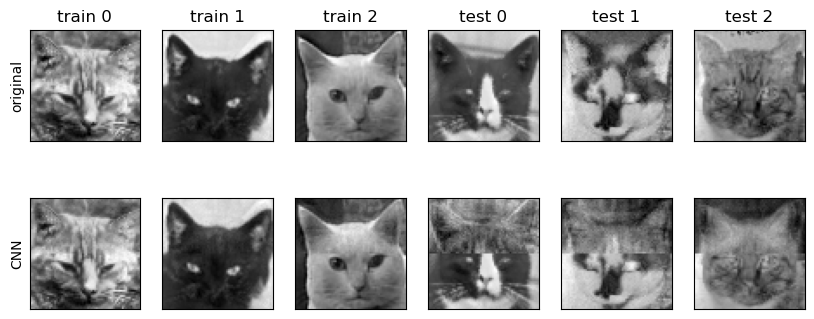

In [20]:
# could be passed accordingly to plotting commands (internally convert to np arrays presumably)
# going to convert here just so I can basically lift code directly from before
X_train_plot = X_train.view(-1, 64*32).numpy()
Y_train_plot = Y_train.numpy()

X_test_plot = X_test.view(-1, 64*32).numpy()
Y_test_plot = Y_test.numpy()

fig, ax = plt.subplots(figsize=(10, 4), nrows=2, ncols=6)

with torch.no_grad():
    Y_pred = model(X_train).view(-1, 64*32).numpy()

for j in range(0, 3):
    ind = ind_train[j]
    ax[0][j].imshow(np.hstack((np.reshape(Y_train_plot[ind, :], (64, 32)), 
                               np.reshape(X_train_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")
    ax[0][j].set_title(f"train {j}")

    ax[1][j].imshow(np.hstack((np.reshape(Y_pred[ind, :], (64, 32)),
                               np.reshape(X_train_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")

with torch.no_grad():
    Y_pred = model(X_test).view(-1, 64*32).numpy()

for j in range(3, 6):
    ind = ind_test[j]
    ax[0][j].imshow(np.hstack((np.reshape(Y_test_plot[ind, :], (64, 32)), 
                               np.reshape(X_test_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")
    ax[0][j].set_title(f"test {j-3}")

    ax[1][j].imshow(np.hstack((np.reshape(Y_pred[ind, :], (64, 32)),
                               np.reshape(X_test_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")

for i in range(2):
    for j in range(6):
        ax[i][j].set_xticks([]); ax[i][j].set_yticks([]);
        if j == 0:
            ax[0][j].set_ylabel("original")
            ax[1][j].set_ylabel("CNN")

> <span style="color:red">Q.</span> As in one of the exercises previously, consider doing classification with CNN but only on one half of the image.
>
> <span style="color:red">Q.</span> When I first made the notebooks I made a mistake and had 10 outputs instead of 2 for the present classification problem, however I seem to be getting better skill with the same settings (I got about 80% accuracy on the test set). Have a look at this and see if there is a reasoning for this or whether it is just a fluke.

---
## c) `Dataset` and `DataLoader` object, and batching

So far the implementation has been quite "raw", and we can tidy this up a little more by leveraging some more functionalities. The first one is the `DataLoader` class in `PyTorch` that helps to manage the data. 

The thing I want to use the `DataLoader` object principally for is ***batching***. So far we have been throwing in all the data in one go for training, and batching here refers to exposing to the model "batches" of data at a time for training. This usually slows down the training per epoch actually, but the model training may in fact converge faster in terms of loss reduction, and the model may be more generalisable. Overall the cost of training may actually go down in terms of time because fewer epochs are needed (even if each epoch is more costly).

> NOTE: For really large datasets you have to do batching, because you may not be able to load all the data at once because of memory reasons.

I am going to be lazy and just going to use the last defined version for the input/output data `X_train` and `Y_train`, which is where input is bottom half of cats, and target output is the top half of cats (and are already defined as `PyTorch` tensors). This is probably bad practice; you can reload the data in the cell below with appropriate copy and pasting instead if you like.

In [21]:
# load data here again if you like


Below code creates a reasonably minimal `Dataset` class for use with the image data above. Note that the three entries a `Dataset` class has to have

* `__init__`, telling the class what things it contains, which in our case it literally is just the input and output tensors (you can have more things; see later sessions)
* `__len__`, the number of samples, which in this case happens to be the size of the first dimension because my data has already be processed in the `(sample_size, feature_dim_1, feature_dim_2, ...)` shape (the "right" shape)
* `__getitem__`, how to grab the sample

> IMPORTANT NOTE!!!
>
> Because of how I've preprocessed the samples in the shape and form `PyTorch` was basically expecting already (with `X_train.view(-1, 1, 64, 32)` above, the first or index zero dimension being the `sample_size` dimension), I could get away with using `len(self.inp)` and `self.inp[idx]` instead of `self.inp.shape[0]` and `self.inp[idf, :, :, :]` or similar. In some other circumstances that may not be true, so you have to be adapt it accordingly to the setting you have.

In [22]:
# define custom dataset to do allow for batching
from torch.utils.data import Dataset, DataLoader

class MyDataset(Dataset):

    def __init__(self, in_tensor, out_tensor):
        self.inp = in_tensor
        self.out = out_tensor

    def __len__(self):
        return len(self.inp)

    def __getitem__(self, idx):
        return self.inp[idx], self.out[idx]

We can define and query the `Dataset` to see what is in there.

In [23]:
# if no change in ordering, the data here is X_train = bottom_half_of_face

train_dataset = MyDataset(X_train, Y_train)
print(f"In  data shape     = {train_dataset.inp.shape}")
print(f"Out data shape     = {train_dataset.out.shape}")
n_sample = train_dataset.__len__()
print(f"Number of  samples = {n_sample}")
random_id = np.random.randint(n_sample)
print(f"Random in  sample =")
print(f"  {train_dataset.__getitem__(random_id)[0]}")
print(f"Random out sample =")
print(f"  {train_dataset.__getitem__(random_id)[1]}")

In  data shape     = torch.Size([56, 1, 64, 32])
Out data shape     = torch.Size([56, 2048])
Number of  samples = 56
Random in  sample =
  tensor([[[1.5033, 1.3145, 0.7238,  ..., 1.4450, 1.3096, 1.1364],
         [1.5187, 1.3567, 0.7583,  ..., 1.3508, 1.2580, 1.1479],
         [1.4763, 1.4024, 1.0053,  ..., 1.3882, 1.3576, 1.1617],
         ...,
         [1.9695, 2.0611, 2.2767,  ..., 1.8439, 1.9219, 1.8308],
         [1.2563, 1.4251, 1.7313,  ..., 1.6807, 1.7678, 1.7221],
         [0.9495, 0.8960, 0.8921,  ..., 1.7483, 1.6882, 1.6744]]])
Random out sample =
  tensor([0.7649, 0.8574, 1.0009,  ..., 1.1279, 1.1877, 1.0304])


The training loop is slightly modified in that we have an additional cycling over a batch loop; during this loop the model sees four pairs of in/out data at a time.

The below initialises a `DataLoader` that is subsequently passed to a training loop. Here I ask for batches of a certain size: `batch_size` as done below is a free argument to be specified through the training loop input. Note that by default it will use the full batch, i.e. no batching. I ask for the batches to be shuffled (`shuffle=True`), which shuffles the order of data that is exposed to the model for traning.

> NOTE: I've opted to not change the inputs of the training subroutine, but add in the initialisation and data loading routines in the loop itself. That's just a matter of preference and convenience for this case, because I already have `X_train` defined. You can do it in other ways (e.g. swap out `X_train` and `Y_train` for `train_dataloader` as an input for the training loop), which may be more suitable if you load data in through `Dataset` and `DataLoader`.

> NOTE: I calculate the training loss slightly differently. The below is an average of the loss over the batches per epoch, weighted by the batch sizes. If I don't do the below it will still spit out some numbers but that would be the loss of the **last** batch instead (which may or may not be a good indicator, who knows).

In [24]:
def training_batch(model, optimizer, J, 
                   X_train, Y_train,
                   X_valid, Y_valid,
                   batch_size=len(X_train),  # by default use full batch (so no batching)
                   num_epochs=500, out_epoch=50):

    # define things to dump into for loss curve
    train_J = np.zeros(num_epochs)
    valid_J = np.zeros(num_epochs)

    # define the dataloader with the 
    train_dataset = MyDataset(X_train, Y_train)
    train_dataloader = DataLoader(train_dataset, 
                                  batch_size=batch_size, 
                                  shuffle=True)

    for epoch in range(num_epochs):

        # reset the running loss each epoch
        running_loss = 0.0

        # iteration step (if full batch then below for loop only runs once anyway)
        for batch_X, batch_Y in train_dataloader:
            model.train()  # put the model in training mode (taping is on)
            optimizer.zero_grad()  # clear gradients if it exists (from loss.backward())
            Y_pred = model(batch_X)  # feed-forward
            J_train = J(Y_pred, batch_Y) # compute loss
            J_train.backward()  # back propagation
            optimizer.step()  # iterate

            # modifying the loss computation slightly
            # print(f'  Batch Loss: {J_train.item():.4f}')
            running_loss += J_train.item() * batch_X.size(0)

        # diagnostics: evaluation of metrics as we go along
        model.eval()   # put the model in evaluation mode (taping is off for diags below)

        epoch_loss = running_loss / len(train_dataloader.dataset)
        
        with torch.no_grad():  # force no taping just in case
            Y_pred = model(X_valid)
            J_valid = J(Y_pred, Y_valid)
            train_J[epoch] = epoch_loss  # modification here
            valid_J[epoch] = J_valid.item()

        if (epoch + 1) % out_epoch == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, "
                + f"Train Loss: {epoch_loss:.4f}, "
                + f"Validation Loss: {J_valid.item():.4f}")

    return model, train_J, valid_J

We do the training and evaluations again: the cells below is essentially copy and paste of a cell at the end of the previous section, except now I call `training_batch` (which has `MyDataset` and `DataLoader` calls within it) with additional arguments put in.

In [25]:
torch.manual_seed(1234)

model = cnn_regression()
learning_rate = 0.0001
J = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)  # default is 0.001

model, train_J, valid_J = training_batch(model, optimizer, J, 
                                         X_train, Y_train,  
                                         X_valid, Y_valid,
                                         batch_size=12,  # new argument
                                         num_epochs=300, out_epoch=20)

Epoch 20/300, Train Loss: 0.6557, Validation Loss: 0.7192
Epoch 40/300, Train Loss: 0.4989, Validation Loss: 0.6159
Epoch 60/300, Train Loss: 0.3898, Validation Loss: 0.5858
Epoch 80/300, Train Loss: 0.2900, Validation Loss: 0.5863
Epoch 100/300, Train Loss: 0.2182, Validation Loss: 0.6382
Epoch 120/300, Train Loss: 0.1674, Validation Loss: 0.6700
Epoch 140/300, Train Loss: 0.1291, Validation Loss: 0.7040
Epoch 160/300, Train Loss: 0.1011, Validation Loss: 0.7322
Epoch 180/300, Train Loss: 0.0770, Validation Loss: 0.7661
Epoch 200/300, Train Loss: 0.0587, Validation Loss: 0.7910
Epoch 220/300, Train Loss: 0.0440, Validation Loss: 0.8224
Epoch 240/300, Train Loss: 0.0327, Validation Loss: 0.8493
Epoch 260/300, Train Loss: 0.0242, Validation Loss: 0.8635
Epoch 280/300, Train Loss: 0.0181, Validation Loss: 0.8814
Epoch 300/300, Train Loss: 0.0136, Validation Loss: 0.8887


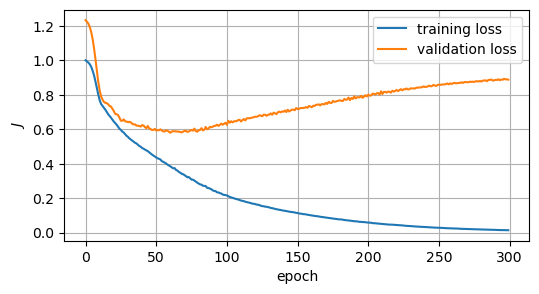

In [26]:
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_J, label="training loss")
ax.plot(valid_J, label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

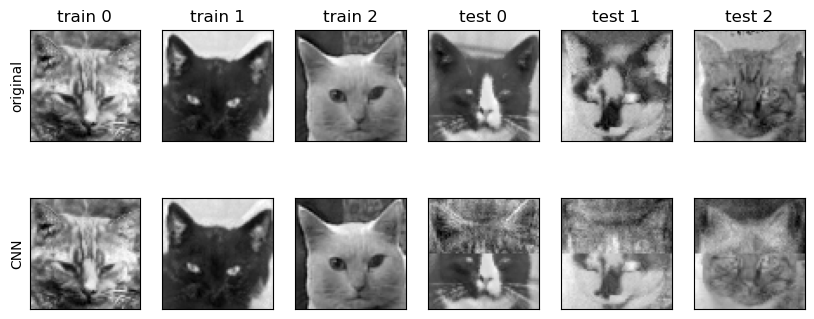

In [27]:
# could be passed accordingly to plotting commands (internally convert to np arrays presumably)
# going to convert here just so I can basically lift code directly from before
X_train_plot = X_train.view(-1, 64*32).numpy()
Y_train_plot = Y_train.numpy()

X_test_plot = X_test.view(-1, 64*32).numpy()
Y_test_plot = Y_test.numpy()

fig, ax = plt.subplots(figsize=(10, 4), nrows=2, ncols=6)

with torch.no_grad():
    Y_pred = model(X_train).view(-1, 64*32).numpy()

for j in range(0, 3):
    ind = ind_train[j]
    ax[0][j].imshow(np.hstack((np.reshape(Y_train_plot[ind, :], (64, 32)), 
                               np.reshape(X_train_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")
    ax[0][j].set_title(f"train {j}")

    ax[1][j].imshow(np.hstack((np.reshape(Y_pred[ind, :], (64, 32)),
                               np.reshape(X_train_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")

with torch.no_grad():
    Y_pred = model(X_test).view(-1, 64*32).numpy()

for j in range(3, 6):
    ind = ind_test[j]
    ax[0][j].imshow(np.hstack((np.reshape(Y_test_plot[ind, :], (64, 32)), 
                               np.reshape(X_test_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")
    ax[0][j].set_title(f"test {j-3}")

    ax[1][j].imshow(np.hstack((np.reshape(Y_pred[ind, :], (64, 32)),
                               np.reshape(X_test_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")

for i in range(2):
    for j in range(6):
        ax[i][j].set_xticks([]); ax[i][j].set_yticks([]);
        if j == 0:
            ax[0][j].set_ylabel("original")
            ax[1][j].set_ylabel("CNN")

Whether the batching in this case gives a better result or not is arguably a bit objective, but it is true the (average) losses in the training data is a bit lower (although the errors in the validation are not that different and large). Anyway, batching here provides an extra hyperparameter one can in principle choose for model training, and again cross validation etc. will be required.

> NOTE: You can save `Dataset` objects separately, allowing you to use Python to load data, preprocess it accordingly, dump it into a `Dataset` object, save it, then you can just load the `Dataset` object with `DataLoader`.

We will do slightly different things using the `Dataset` objects in due course; for more practice, see an extended exercise below, or make your own with e.g. MNIST data, FashionMNIST, penguin data, wine data etc. through ones in `sklearn` (see also extended exercise in the first session, or see [here](https://scikit-learn.org/stable/datasets.html)).

---
## d) Interface with `keras`

[`Keras`](https://keras.io/) you can think of as an interface on top of the `PyTorch`, `TensorFlow` and/or `JAX` engines, and most of them will make your life that bit easier.

Doing it the low-ish level way like I've been doing allows more fine-tuned control in a more obvious way to me at least, although I gather you can get pretty good control through `keras` (requires passing more things through etc.). Below is a demonstration and some introductory pointers of how to use `keras` for the CNN regression problem.

> NOTE: [`Lightning`](https://lightning.ai/docs/pytorch/stable/) is another one that works with `PyTorch`.

Below loads various bits of `keras`, as well as force `keras` to use the `PyTorch` backend (which by default is `TensorFlow`). Adding an additional command to check for availability of GPUs.

In [28]:
import os
os.environ["KERAS_BACKEND"] = "torch"  # use PyTorch as backend

import keras
import keras.layers as layers  # where the hidden layer routines live

# force a clean keras session (clears models etc.)
keras.backend.clear_session()

# chhck cpu or gpu: since using torch as backend, use torch command to check (?)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Active device: {device}")

num_gpu = torch.cuda.device_count()
print(f"Running on {num_gpu} GPUs")

Active device: cpu
Running on 0 GPUs


One thing that `keras` does slightly different is the ordering when dealing with image data (although this can be changed). PyTorch normally wants `(sample_size, channel, height, width)`, but `keras` by default wants it as `(sample_size, height, width, channel)`. You can in principle override the `keras` default with a call of `keras.backend.set_image_data_format('channels_last')`, which will apply the change globally. 

However here I have direct access to the data in memory already, so I am actually going to just change the ordering of the data dimension (with `.permute(dimensions)`), dump it into the same custom `Dataset` object above, and then parse it to a `DataLoader` object that will be passed to `keras`.

> NOTE: If you load from the `PyTorch` database (e.g. MNIST dataset from `torchvision`) then you can load `torchvision.transform` and pass the `transform` and `target_transform` keywords accordingly to the `DataLoader` object to transform the data. The same applies to loading a your custom `Dataset` object through the `DataLoader`.
>
> You can also define the `transform` and `target_transform` routines in you `Dataset` object under `__getitem__`.

In [29]:
# use the objects defined above already, but put in the shape keras expects by default
#    (0, 1, 2, 3) = (sample, channel, height, width) 
# -> (0, 2, 3, 1) = (sample, height, width, channel) 
train_dataset = MyDataset(X_train.permute(0, 2, 3, 1), Y_train)
valid_dataset = MyDataset(X_valid.permute(0, 2, 3, 1), Y_valid)
test_dataset = MyDataset(X_test.permute(0, 2, 3, 1), Y_test)

# going to use full batch (i.e. no batching); can change this if you want
batch_size = 56  # train_dataset.inp.shape[0] would be more robust
train_dataloader = DataLoader(train_dataset, 
                              batch_size=batch_size, 
                              shuffle=True)
# these two below don't need batching because they are not used to compute updates
valid_dataloader = DataLoader(valid_dataset, shuffle=True)
test_dataloader = DataLoader(test_dataset, shuffle=True)

# output the shape just for checking purposes
data_iter = iter(train_dataloader)
images, labels = next(data_iter)

print(f"batch shape: {images.shape}")
print(f" ")

batch shape: torch.Size([56, 64, 32, 1])
 


Below we define the regression CNN with the same layout as above but using the `keras` syntax (note this is not the only way of doing it). Few things to note with regards to syntax:

* I don't need to specify `in_channels` as I did for `PyTorch`, since that is inferred from the output resulting from the last relevant operation.
* The first argument in `Conv2D` is the `out_channels`.
* `kernel_size` and `pool_size` are self-explanatory, and the strides/dilations take the defaults (1 and 1).
* The `flatten` replaces the `.view(-1, whatever)`.
* The output here is an array of 2048 pixels as before, which will need reshaping for visualisation.

I then call `model.summary()` which provides a summary of what is in the model.

> NOTE: You could do
>
```Python
inputs = keras.Input(shape=input_shape)
# first layer
x = layers.Conv2D(6, kernel_size=(5, 5), activation="relu")(inputs)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
# second layer
x = layers.Conv2D(10, kernel_size=(5, 5), activation="relu")(x)

...

# outputs
outputs = layers.Dense(64*32)(x)

model = keras.Model(inputs=inputs, outputs=outputs)
```

> which ends up taping the sequence of operations. Note however `model.summary()` looks slightly different; try this yourself to see what is different (it is inconsequential as far as I can tell).
>
> You can also wrap it up into subroutines, which will be cleaner and every time you call the initialisation through the subroutine it should be fresh, which is not the case below (I do do this from the next session onwards).

In [30]:
# define the CNN architecture
input_shape = (64, 32, 1)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(6, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(10, kernel_size=(5, 5), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(1000, activation="relu"),
        layers.Dense(64*32),
    ],
    name = "CNN regression"  # give the model a name if you want
)

# prints out a summary of the model
model.summary()

Model: "CNN regression"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 28, 6)      │           156 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 14, 6)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 10, 10)     │         1,510 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 5, 10)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 650)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1000)           │       651,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     2,050,048 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,702,714 (10.31 MB)

 Trainable params: 2,702,714 (10.31 MB)

 Non-trainable params: 0 (0.00 B)

Then we define the optimisers, loss and etc. These are done with the `.compile()` routine attached to the defined `model`. The losses and optimizers can be found in `keras.losses` and `keras.optimizers` as expected (you could have done `import keras.losses as losses` or similar about to save reduce the code length). 

You can get `keras` to output additional metrics during the training, but note it expects a list. For this one MSE is the loss and that is already outputted, but you could get it to compute MAE as well if you like (although that plays no role in the optimisation problem itself).

In [31]:
learning_rate = 0.0001

model.compile(loss=keras.losses.MeanSquaredError(), 
              optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
              # metrics=[keras.metrics.Accuracy()],
             )

Now we can go ahead and train model with `.fit`, passing in the `train_dataloader` (which `keras` understands as including both input/output data), and number of `epochs` to train; I selected a small number for reasons that should become clear quickly. Observe here I didn't need to write a training loop separately.

> NOTE: If you don't wrap it up as a `DataLoader` object then you could just throw in even `numpy` data as `model.fit(X_train, Y_train, ...)`, as `keras` will basically convert the data for you accordingly. (For example, the toy datasets that comes with `keras.datasets` are actually `numpy` arrays.)
>
> Here I pass in a `DataLoader` object so I don't specify the `batch_size` that can be taken by `model.fit()`, because it will be ignored in favour for the `batch_size` defined in the `DataLoader` object. If you passed in `numpy` or `tensor` objects then you could specify `batch_size` in `.fit()` instead to do batching without re-writing the training loop as I did above. I do both of the above in the next session as a demonstration.

In [32]:
train_log = model.fit(train_dataloader, 
                      epochs=15);

Epoch 1/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step - loss: 1.0176
Epoch 2/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - loss: 1.0120
Epoch 3/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - loss: 1.0068
Epoch 4/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step - loss: 1.0018
Epoch 5/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step - loss: 0.9971
Epoch 6/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - loss: 0.9926
Epoch 7/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step - loss: 0.9883
Epoch 8/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - loss: 0.9840
Epoch 9/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step - loss: 0.9797
Epoch 10/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - loss: 0.9754
Epoch 11/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - loss: 0.9709
Epoch 12/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - loss: 0.9663
Epoch 13/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - loss: 0.9614
Epoch 14/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step - loss: 0.9563
Epoch 15/15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - loss: 0.9510


And that's basically it! The model is trained and every epoch it gets trained it spits out diagostics we asked for. I define the variable `train_log` for plotting of loss functions as a function of epoch, and I will do the plotting shortly.

We probably don't want output every epoch if we are training for several hundreds of epoch though. There are ways to control the output with more finesse (e.g. though use of `Callbacks`), but I am going to use `tqdm`, which you may need to download if you are doing this on your own machine (Colab has `tqdm`). Below I call the training again but for more epochs. **Note that because I didn't re-initialise the model, it continues from where it left off** (at the last epoch it was trained to, just like how an implementation in `PyTorch` would behave also). This is potentially desirable as you can save the model every so often and restart if you so wish, but just be aware this is a thing that happens.

Below I am going to pass the the validation dataset (`valid_dataloader`) to `.fit` so it will spit out some things related to the validation loss also.

> NOTE: If you change `verbose=2` then you get information at every batch as well. Below you should get two updating bars, the first one telling you where the training progress over epochs, and the second one for the validation data.
>
> For `validation_data` you could pass a tuple `(X_valid, Y_valid)` instead of a `DataLoader` object.

In [33]:
from tqdm.keras import TqdmCallback

train_log = model.fit(train_dataloader, 
                      epochs=300,
                      validation_data=valid_dataloader,  # validation data
                      verbose=0, # Disable Keras default output
                      callbacks=[TqdmCallback(verbose=1)],  # "1" gives progress of batch
                     )

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

We can query the `train_log` variable to get the loss curve, which is roughly what we had before (with an offset of 15 epochs I suppose).

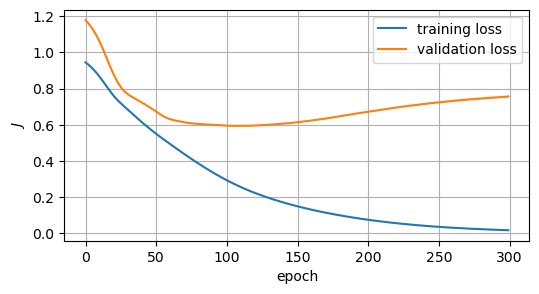

In [34]:
# loss curve (note an offset by 15 epochs because I didn't reinitialise)
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_log.epoch, train_log.history["loss"], label="training loss")
ax.plot(train_log.epoch, train_log.history["val_loss"], label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

The performance on the test set data may be evaluted by passing calling `model.evaluate()` on `test_dataloader` (which has the input/output data in it), and then query the resulting variable. The below gets the MSE (because that is the loss) of the test set, and it's bigger than 1, so it's not good, as we expected.

> NOTE: Again you could pass in `X_test` and `Y_test` instead.

In [35]:
diags = model.evaluate(test_dataloader)

print(f"loss = {diags:.6f}")

# if specifying a list of metrics, can use below
# for i, metric in enumerate(model.metrics_names):
#     print(f"{metric} = {diags[i]:.6f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.9822
loss = 0.982152


We can actually see what the outputs are using `model.predict()`. You can pass in `numpy`, `tensor` or even `DataLoader` objects in (it basically ignores the output data portion). Below is basically copy-and-paste of something from above, with the predict line modified.

> NOTE: Here I am really passing in `tensors` because I am calling the data in `Dataset` directly. By default I am doing the prediction on the whole dataset; you may not want to do this if the sample size is big.
>
> I may instead want to predict a small batch at a time, which you can do by specifying the indices in `sample_size`. If you want to predict ***one*** at a time though you have to be careful, because it wants the input to have a `sample_size` dimension it seems; you can fudge this in with e.g. `model.predict(train_dataset.inp[0].view(-1, 64, 32, 1))` (just make a dummy index 0 dimension).

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step


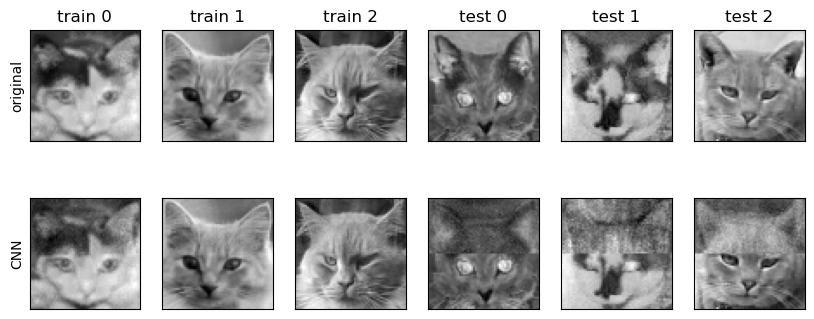

In [36]:
# could be passed accordingly to plotting commands (internally convert to np arrays presumably)
# going to convert here just so I can basically lift code directly from before
X_train_plot = X_train.view(-1, 64*32).numpy()
Y_train_plot = Y_train.numpy()

X_test_plot = X_test.view(-1, 64*32).numpy()
Y_test_plot = Y_test.numpy()

ind_train = np.arange(train_sample)
np.random.shuffle(ind_train)

ind_test = np.arange(test_sample)
np.random.shuffle(ind_test)

fig, ax = plt.subplots(figsize=(10, 4), nrows=2, ncols=6)

# predictions are numpy arrays
Y_pred = model.predict(train_dataset.inp[:])

for j in range(0, 3):
    ind = ind_train[j]
    ax[0][j].imshow(np.hstack((np.reshape(Y_train_plot[ind, :], (64, 32)), 
                               np.reshape(X_train_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")
    ax[0][j].set_title(f"train {j}")

    ax[1][j].imshow(np.hstack((np.reshape(Y_pred[ind, :], (64, 32)),
                               np.reshape(X_train_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")

# predictions are numpy arrays
Y_pred = model.predict(test_dataset.inp[:])  # already an numpy array

for j in range(3, 6):
    ind = ind_test[j]
    ax[0][j].imshow(np.hstack((np.reshape(Y_test_plot[ind, :], (64, 32)), 
                               np.reshape(X_test_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")
    ax[0][j].set_title(f"test {j-3}")

    ax[1][j].imshow(np.hstack((np.reshape(Y_pred[ind, :], (64, 32)),
                               np.reshape(X_test_plot[ind, :], (64, 32)))).T, 
                    cmap="gray")

for i in range(2):
    for j in range(6):
        ax[i][j].set_xticks([]); ax[i][j].set_yticks([]);
        if j == 0:
            ax[0][j].set_ylabel("original")
            ax[1][j].set_ylabel("CNN")

The things I certainly gain from using `keras` are that:

* I don't need to write training loops unless I want more control on it.
* I don't need to manually put my models in training or prediction mode (cf. `model.train()` and `model.eval()` in `PyTorch` training loop).
* The interface is more user friendly, and you get a nice summary of the number of degrees of freedom which is useful to know (although I think `PyTorch` was fine).
* It is more flexible in terms of data types and conversions.
* You gain some complexity reduction with specifying the neural network architecture  (not all though: you still need to work out what the data shapes are at every step otherwise it will complain, so not getting pass that, but there are quite a few ways to "cheat"; see next session).

Most/all things you can do in `PyTorch` you can do in `keras` I assume. In the subsequent notebooks I will go between the two approach or maybe use a (unholy) mix of the two depending on context (e.g. for PINNs I will do it the old fashioned way partly because of things like `torch.grad`, and leave it as an execise for you to figure out how to pipe it through `keras`).

> <span style="color:red">Q.</span> Do the cats and dogs classification task through `keras`.
>
> You will need to swap out the loss function, which may give you some extra issues/headaches (e.g. converting the labels to a form `keras` wants for choice of loss function; `Y_train = keras.utils.to_categorical(label, 2)` for the cats and dogs problem may be one of your friends here).

----------------
# More involved exercises with this notebook

## 1) `DataLoader` and `keras` interface for the MLP notebook

Do the same `PyTorch` and `keras` things but for the previous notebook for further practice (should be self-explanatory, just use `layers.Dense`).

## 2) CNN structure

Consider playing around with the sizes of the convolution and pooling layer sizes etc. I would stick with the classification problem because size of problem reasons. This is probably easier to do through `keras`.

## 3) More on `Dataset` and `DataLoader`

The way I have created the `Dataset` object above is to load the data into memory, define the `Dataset` object, then use it. You can argue this defeats the point because what I might want to do is to read the data from file directly through the `Dataset` object, and I can't do this if the dataset is really big. 

That is certainly true, and you are encouraged to try and do that by adding appropriate commands to the `Dataset` object. You will need to have ways to transform that data into tensors with the right shapes that `PyTorch` and/or `keras` is expecting. Have a look at [here](https://docs.pytorch.org/tutorials/beginner/basics/data_tutorial.html) for some help using the FashionMNIST data.

The added bonus of doing this is that the computer will then be set up cleverly enough to only load the relevant data onto memory when it is used in the batches, i.e. not all data is on there at the same time, which is important if you dataset is really big.

> NOTE: For this one I am afraid my advcie is to struggle and fail a few times, which will highlight what things are failing and what the messages look like so that you know how to fix things later on...

## 4) Time series data

We will revisit time-series data again in a few sessions, but generate some time series data (e.g. as a sine wave or solving some differential equation if you like; see next session), and try deploying CNN for time series data via learning convolutions in the time dimension. You probably want to use `Conv1d` for this.

The difference with doing this compare to the ***RNN*** approaches next session is that both of these learn local patterns in some way, but the RNN approach uses a ***hidden state*** that represents a memory block, while the CNN approach is really just trying to find local patterns. 

## 5) e.g. MNIST dataset

Try and use CNN on the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset, through `PyTorch` or `keras` (or do both for an extra challenge; see later why).

* For `PyTorch` you can load this through `torchvision`, which you may need to install through `conda` if you are using this on your own machine (Colab has it already).
* For `keras`, this is there already in `keras.dataset`.

See [here](https://keras.io/examples/vision/mnist_convnet/) for a suggested CNN structure that supposedly works well enough. Following the above `keras` example and doing cut-and-paste is easy and not overly informative maybe. The challenge is to try the following:

* Port all the above using the data in `keras.dataset` (which are `numpy` arrays) and do the training in `PyTorch`
* Load the data from `torchvision` and do the same in `PyTorch` (as `Dataset` or better as a `DataLoader` object)
* Load the data from `torchvision` and do it in `keras`

The last one is a bit annoying to do as a `DataLoader` object, but will highlight quite a lot of ugly things with data processing that is probably one of the more annoying bottlenecks for doing Machine Learning (i.e. getting the data into a form that the machine can do things with)...